## Assignment III - AI ML

### **Loading and inspecting the data**: created a pd.DataFrame for simpler handling of data. Modified code to ensure **balanced classes** for "has_spoiler"

In [81]:
import gzip
import json
import pandas as pd

# Define file path
file_path = "data/goodreads_reviews_spoiler.json.gz"

# Initialize counters for balancing
data = []
max_samples_per_class = 10000  # Number of samples per class (adjust as needed)
spoiler_count = 0
no_spoiler_count = 0

# Open the .gz file and read the reviews
with gzip.open(file_path, 'rt', encoding='utf-8') as fin:  # Open file in text mode
    for line in fin:
        review = json.loads(line)  # Parse JSON
        
        # Check the 'has_spoiler' field and balance the classes
        if review['has_spoiler'] and spoiler_count < max_samples_per_class:
            data.append(review)
            spoiler_count += 1
        elif not review['has_spoiler'] and no_spoiler_count < max_samples_per_class:
            data.append(review)
            no_spoiler_count += 1

        # Stop if both classes are balanced
        if spoiler_count >= max_samples_per_class and no_spoiler_count >= max_samples_per_class:
            break

# Convert data to a pandas DataFrame for easier handling
df = pd.DataFrame(data)
print(f"Loaded {len(df)} samples: {spoiler_count} Spoilers, {no_spoiler_count} No Spoilers")


Loaded 20000 samples: 10000 Spoilers, 10000 No Spoilers


### **Data Cleaning**: NA values, string format, filtering relevant data

In [43]:
# Drop rows with missing values in the relevant columns
df = df.dropna(subset=['review_sentences', 'has_spoiler'])
print(df.info())  # Verify the changes

# Combine sentences into a single string
df['review_text'] = df['review_sentences'].apply(lambda x: ' '.join([sentence[1] for sentence in x]))
print(df['review_text'].head())  # Check the transformed reviews

# Create a new DataFrame with the relevant columns
df = df[['review_text', 'has_spoiler']]
print(df.head())  # Verify the final DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           20000 non-null  object
 1   timestamp         20000 non-null  object
 2   review_sentences  20000 non-null  object
 3   rating            20000 non-null  int64 
 4   has_spoiler       20000 non-null  bool  
 5   book_id           20000 non-null  object
 6   review_id         20000 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 957.2+ KB
None
0    This is a special book. It started slow for ab...
1    Recommended by Don Katz. Avail for free in Dec...
2    A fun, fast paced science fiction thriller. I ...
3    Recommended reading to understand what is goin...
4    I really enjoyed this book, and there is a lot...
Name: review_text, dtype: object
                                         review_text  has_spoiler
0  This is a special book. It started 

### **Pre-processing data**: target encoding, tokenization, padding

In [44]:
# Encode target variable
df['has_spoiler'] = df['has_spoiler'].astype(int)


In [45]:
from sklearn.model_selection import train_test_split

# split data into train, val, and test sets
X = df['review_text']
y = df['has_spoiler']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [46]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Initializing and fitting tokenizer on train set
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Only consider the top 10,000 words
tokenizer.fit_on_texts(X_train)  # Fit on training data only

# Tokenization and padding:
max_length = 100  # Maximum length of padded sequences

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Step 4: Confirm the shapes of the processed datasets
print(f"Training data shape: {X_train_pad.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val_pad.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test_pad.shape}, Labels: {y_test.shape}")


Training data shape: (14400, 100), Labels: (14400,)
Validation data shape: (1600, 100), Labels: (1600,)
Test data shape: (4000, 100), Labels: (4000,)


### **Section 1**: Implementing and Training an LSTM Network

#### **Baseline architecture**: Embedding layer, LSTM layer, Dropout, Dense output layer (Adam opt & binary cross entropy)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model
lstm0 = Sequential([
    Embedding(input_dim=10000,  # vocabulary size (from tokenizer)
              output_dim=128,   # embedding dimensions
              input_length=100),  # input sequence length (padded length)

    # LSTM
    LSTM(64, return_sequences=False),  # 64 units
    Dropout(0.5),   # dropout to prevent overfitting

    Dense(1, activation='sigmoid')  # output
])

# Compile
lstm0.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy',       
              metrics=['accuracy'])         

# Print the model summary
lstm0.summary()


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Callbakcs and training

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = lstm0.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10,batch_size=32, callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/10


450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6749 - loss: 0.6167 - val_accuracy: 0.6331 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7521 - loss: 0.5216 - val_accuracy: 0.7325 - val_loss: 0.5468 - learning_rate: 0.0010
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8113 - loss: 0.4307 - val_accuracy: 0.7262 - val_loss: 0.5669 - learning_rate: 0.0010
Epoch 4/10
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8553 - loss: 0.3297
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8553 - loss: 0.3297 - val_accuracy: 0.7094 - val_loss: 0.6268 - learning_rate: 0.0010
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9219 - loss: 0.2190 - val_accuracy: 0.7106 - val_loss: 0.8327 - learning_rate: 5.0000e-04
Epoch 6/10
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9457 - loss: 0.153

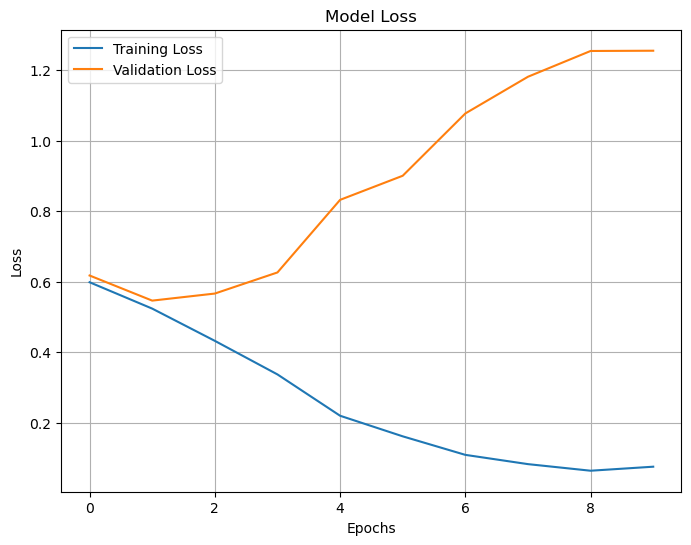

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7301 - loss: 0.5516
Test accuracy: 0.73
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

  No Spoiler       0.75      0.70      0.72      2007
     Spoiler       0.72      0.76      0.74      1993

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# plot model loss
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(history)
test_loss, test_accuracy = lstm0.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_prob = lstm0.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary (0/1)

report = classification_report(y_test, y_pred, target_names=['No Spoiler', 'Spoiler'])
print(report)



**Interpretation**: the plot shows overfitting. While the training loss decreases steadily (learns the training data very well), the validation loss starts to increase after epoch 4. 

Also, the precision is higher for "Spoiler" while recall is higher for "No Spoiler." This suggests the model has a slight bias toward predicting "Spoiler." --> maybe include class weights to adress this bias

**Next Steps**: address overfitting by reducing complexity, and higher regularization (higher dropout and inclusion of penalization). Add bidirectionality to add context and improve performance.

#### lstm1: reduced complexity, higher dropout and regularization. 

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

lstm1 = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    
    LSTM(16, return_sequences=False, kernel_regularizer=l2(0.01)),  # reduced # of units from 64 to 16
    
    Dropout(0.6),   # increased dropout from 0.5 to 0.6
    
    Dense(1, activation='sigmoid')
])

# Compile
lstm1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [55]:
# Callbakcs and training

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = lstm1.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10,batch_size=32, callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10


450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6630 - loss: 0.8696 - val_accuracy: 0.6694 - val_loss: 0.6102 - learning_rate: 0.0010
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6965 - loss: 0.5888 - val_accuracy: 0.7344 - val_loss: 0.5594 - learning_rate: 0.0010
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7761 - loss: 0.5143 - val_accuracy: 0.7269 - val_loss: 0.5449 - learning_rate: 0.0010
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8194 - loss: 0.4522 - val_accuracy: 0.7287 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 5/10
445/450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8442 - loss: 0.4115
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8441 - loss: 0.4116 - val_accuracy: 0.7163 - val_loss: 0.5911 - learning_rate: 0.0010
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8772 - loss: 0.3468 - val_ac

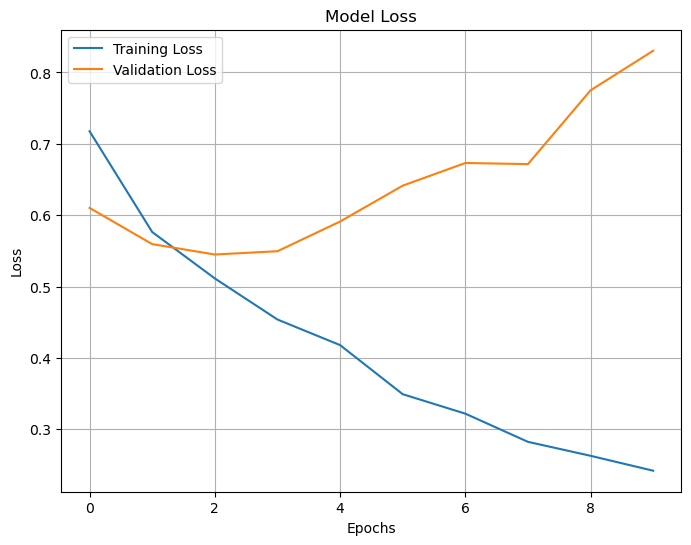

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7242 - loss: 0.5529
Test accuracy: 0.73
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

  No Spoiler       0.74      0.71      0.72      2007
     Spoiler       0.72      0.75      0.74      1993

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# plot model loss
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(history)
test_loss, test_accuracy = lstm1.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_prob = lstm1.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary (0/1)

report = classification_report(y_test, y_pred, target_names=['No Spoiler', 'Spoiler'])
print(report)

**Interpretation**: Same test accuracy of 0.73. Training loss decreases steadily; Val loss still increases after epoch 4. The gap shows overfitting still

**Next Steps**: Increase regularization and lower lr

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

lstm2 = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    
    LSTM(16, return_sequences=False, kernel_regularizer=l2(1e-1)), # increased regularization value
    Dropout(0.7),   # increased dropout

    Dense(1, activation='sigmoid')
])

# Compile
lstm2.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy']) # lowered lr

/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [60]:
# Callbakcs and training

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = lstm2.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10,batch_size=32, callbacks=[early_stopping, lr_scheduler])

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6011 - loss: 6.0286 - val_accuracy: 0.6737 - val_loss: 3.8814 - learning_rate: 1.0000e-04
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6720 - loss: 3.4040 - val_accuracy: 0.6700 - val_loss: 2.2340 - learning_rate: 1.0000e-04
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6663 - loss: 1.9817 - val_accuracy: 0.6719 - val_loss: 1.3644 - learning_rate: 1.0000e-04
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6641 - loss: 1.2384 - val_accuracy: 0.6719 - val_loss: 0.9297 - learning_rate: 1.0000e-04
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6724 - loss: 0.8707 - val_accuracy: 0.6719 - val_loss: 0.7313 - learning_rate: 1.0000e-04
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6620 - loss: 0.7132 - val_accuracy: 0.6719 - val_loss: 0.6508 - learning_rate: 1.0000e-04
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - acc

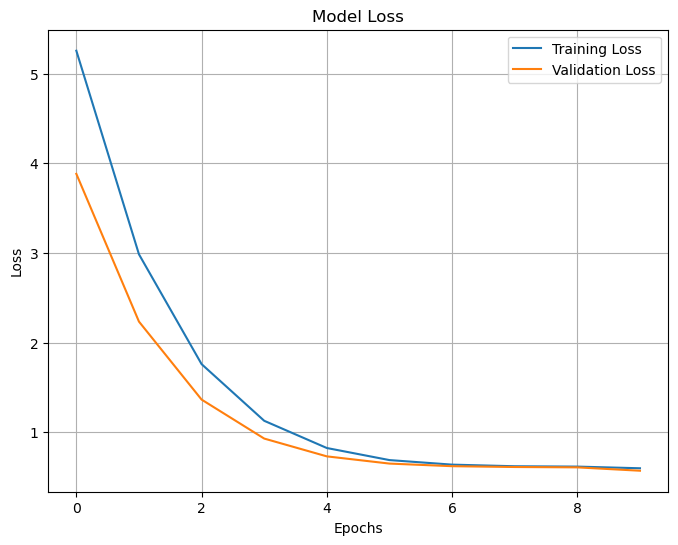

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7242 - loss: 0.5529
Test accuracy: 0.73
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

  No Spoiler       0.83      0.53      0.65      2007
     Spoiler       0.65      0.89      0.75      1993

    accuracy                           0.71      4000
   macro avg       0.74      0.71      0.70      4000
weighted avg       0.74      0.71      0.70      4000



In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# plot model loss
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(history)
test_loss, test_accuracy = lstm1.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_prob = lstm2.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary (0/1)

report = classification_report(y_test, y_pred, target_names=['No Spoiler', 'Spoiler'])
print(report)

**Interpretation**: Stagnation at test accuracy 0.73. Training saturation meaning the current architecture reached a cap in performance. This stagnation could be due to lack of model compexity, which essentially goes against my inital thought that the model was overfitting due to being overly complex for this task (depite having a super simple architecture). 

**(NOT IN NOTEBOOK:)** However, I did explore adding complexity (by increasing units and LSTM layers, including bidirectional layers) but I did not achieve better test accuracy. I should probably review this as I most likely made a mistake. 

**For the future**: Explore other, more complex archtectures by increasing number of units, number of LSTM layers, etc. 

### **Section 2**: Exploring the GRU Architecture (Theory)

**Note**: Results were retrieved from ChatGPT due to efficiency in gathering information from a single place and time constraints (I still made sure I understand what is hapenning)


A **Gated Recurrent Unit (GRU)** is a type RNN designed to address the **vanishing gradient** problem commonly found in vanilla RNNs. It simplifies the structure of an LSTM by combining and reducing the number of gates, making it computationally efficient.

**Key Components of a GRU Cell**
A GRU cell consists of the following gates and mechanisms:

**Update Gate (z𝑡)**:

* Controls how much of the previous memory (hidden state) should be carried forward into the current time step.

* Similar to the forget gate and input gate combined in an LSTM.

* Formula: $$z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$$


**Reset Gate (r𝑡)**:

* Decides how much of the previous hidden state information should be ignored when calculating the new memory.

* Formula: $$r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)$$

**Candidate Hidden State (h𝑡)**:

* A potential memory content that combines the current input and the reset-filtered previous hidden state.

* Formula: $$\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)$$

**Final Hidden State (h𝑡)**:

* Combines the candidate hidden state and the previous hidden state based on the update gate.

* Formula: $$h_t = z_t \odot h_{t-1} + (1 - z_t) \odot \tilde{h}_t$$


**Visualization of a GRU Cell**:

              ┌──────────┐
         xt → │  Update  │ → (1 - zt) ⊗ Candidate Hidden State
              │   Gate   │
         ht-1 │  zt      │
              └──────────┘
                 ↓
              ┌──────────┐
         xt → │  Reset   │ → ⊗ ht-1 → Candidate Hidden State
              │   Gate   │
         ht-1 │  rt      │
              └──────────┘


**Comparison: GRU vs. LSTM**:

| **Feature**                  | **GRU**                                                   | **LSTM**                                                        |
|------------------------------|----------------------------------------------------------|-----------------------------------------------------------------|
| **Number of Gates**           | 2 (Update Gate, Reset Gate)                              | 3 (Forget Gate, Input Gate, Output Gate)                       |
| **Memory Cells**              | No separate memory cell; hidden state combines input and memory. | Separate memory cell \( c_t \) and hidden state \( h_t \).      |
| **Complexity**                | Simpler, fewer parameters.                               | More complex, more parameters.                                 |
| **Computational Efficiency**  | Faster due to fewer gates and parameters.               | Slower due to additional gates and computations.               |
| **Suitability for Small Data**| Performs better on smaller datasets due to simplicity.  | Requires larger datasets to fully leverage its complexity.     |
| **Performance on Long Sequences** | May struggle with very long-term dependencies.       | Better at capturing very long-term dependencies.               |





**When to Use GRU vs. LSTM**

**Use GRU When:**

* You need a faster model with fewer resources (e.g., mobile devices).

* The dataset is small or moderately sized.

* Capturing short-to-medium-term dependencies is sufficient.

**Use LSTM When:**

* You need to model long-term dependencies effectively.

* The dataset is large enough to train a more complex model.

* Fine-grained control over the information flow is critical.



**Trade-offs**

**Efficiency vs. Performance:**

* GRUs are computationally cheaper but may lose information over long sequences.

* LSTMs are better at handling complex patterns in large, rich datasets but require more computational resources.

**Interpretability:**

* GRUs are easier to interpret due to fewer gates.

* LSTMs provide more control and granularity over how information flows.



**Conclusion**: Probably better to use GRU layer for our data because of the limited used (14000)

### **Section 3**: Implementing and Training a GRU Network

#### **gru0**: Adapting the lstm2 architecture (high regularization, dropout and low lr) to GRU (I am trying this parameters as they proved to improve training and stability)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

gru0 = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    
    GRU(16, return_sequences=False, kernel_regularizer=l2(1e-1)), # increased regularization value
    Dropout(0.7),   # increased dropout

    Dense(1, activation='sigmoid')
])

# Compile
gru0.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy']) # lowered lr

/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
# Callbakcs and training

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = gru0.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10,batch_size=32, callbacks=[early_stopping, lr_scheduler])

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6074 - loss: 5.3960 - val_accuracy: 0.6737 - val_loss: 3.6176 - learning_rate: 1.0000e-04
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6726 - loss: 3.2096 - val_accuracy: 0.6737 - val_loss: 2.1851 - learning_rate: 1.0000e-04
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6701 - loss: 1.9615 - val_accuracy: 0.6706 - val_loss: 1.3829 - learning_rate: 1.0000e-04
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6764 - loss: 1.2654 - val_accuracy: 0.6694 - val_loss: 0.9586 - learning_rate: 1.0000e-04
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6630 - loss: 0.9078 - val_accuracy: 0.6700 - val_loss: 0.7533 - learning_rate: 1.0000e-04
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6711 - loss: 0.7262 - val_accuracy: 0.6700 - val_loss: 0.6644 - learning_rate: 1.0000e-04
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - acc

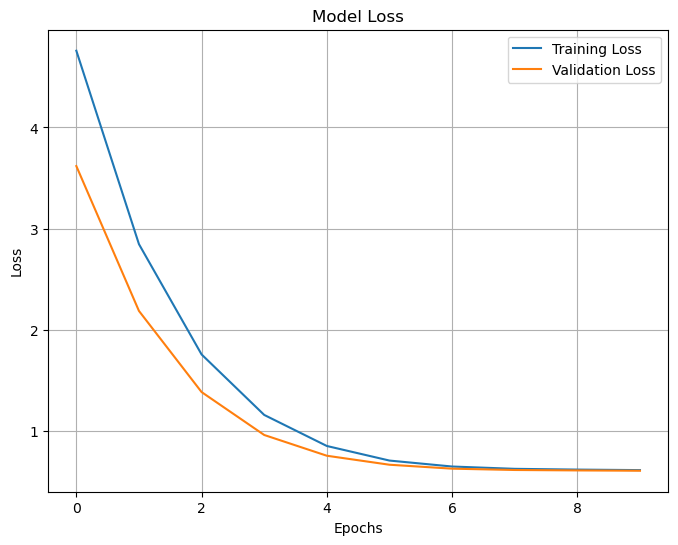

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6675 - loss: 0.6050
Test accuracy: 0.68
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

  No Spoiler       0.83      0.53      0.65      2007
     Spoiler       0.65      0.89      0.75      1993

    accuracy                           0.71      4000
   macro avg       0.74      0.71      0.70      4000
weighted avg       0.74      0.71      0.70      4000



In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# plot model loss
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(history)
test_loss, test_accuracy = gru0.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_prob = lstm2.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary (0/1)

report = classification_report(y_test, y_pred, target_names=['No Spoiler', 'Spoiler'])
print(report)

**Interpretation**:

Both val_loss and train_loss decrease srteadily and converge rapidly showing stable training (validating choice of regularization, dropout and lr)

**LSTM outperformed GRU**:
Test accuracy decreased (LSTM: 0.73; GRU: 0.68). Precision, recall and F1 scores were also lower for GRU compared to LSTM. LSTM had a slightly smoother convergence suggesting that its additional gates helped better interpret long-term dependancies.

**Complexity and Training time**: GRU training time was faster, maked sense since it has fewer parameters. However, the difference was not that significant, LSTM trianed pretty fast for me (but it did took longer than GRU)


**Pros and Cons**:

LSTM had higher test accuracy and better balance between precision and recall, making it more suitable for this task. The additional gates probably helped capture more complexity proving to be better for long-term dependencies. However, since more gates means more parameters it took longer to train (higher computational cost). This was minimal for this task and machine however. 

GRU's simpler architecture (fewer gates and parameters) made it faster and less expensive. In theory, GRUs perform well on smaller datasets or tasks with shorter sequences. I thought that was the case for this dataset (imagined that 14000 for training set may not be sufficient to capture enough complexity), but results proved me wrong, the task did require managing significant longer-term dependencies. GRU's simpler design may have struggled in capturing these resulting in lower test accuracy.

In conclusion, for tasks relying on relatively high long-term patterns or longer sequences (like this case, as it turned out to be) LSTM perform better due to added complexity.

### **Section 4**: Exploring and Testing Optimization Algorithms for Recurrent Neural Networks

#### **Part A**: Theory – Understanding Optimization Algorithms

#### Optimization Algorithms for Training RNNs

#### **1. Stochastic Gradient Descent (SGD)**

**Purpose and Mechanism**
- **Purpose**: Optimize the neural network by iteratively adjusting weights to minimize the loss function.
- **Mechanism**:
  - At each step, weights are updated based on the gradient of the loss function with respect to weights.
  - **Update Rule**:
    $$
    w = w - \eta \cdot \nabla L(w)
    $$
    - \( \eta \): Learning rate.
    - \( \nabla L(w) \): Gradient of the loss.

**Advantages**
- **Simple and Efficient**: Computationally lightweight for small datasets.
- **Frequent Updates**: Makes quick progress towards minima.

**Disadvantages**
- **Instability**: Can oscillate or diverge near minima if the learning rate is too high.
- **Slow Convergence**: May struggle to escape shallow local minima or plateaus.

---

#### **2. SGD with Momentum**

**Purpose and Mechanism**
- **Purpose**: Overcome SGD’s instability and slow convergence by incorporating momentum, which builds velocity to dampen oscillations and speed up convergence.
- **Mechanism**:
  - Introduces a momentum term \( v \), which adds a fraction of the previous update to the current update:
    $$
    v = \gamma \cdot v + \eta \cdot \nabla L(w)
    $$
    $$
    w = w - v
    $$
    - \( \gamma \): Momentum coefficient (usually 0.9).

**Advantages**
- **Faster Convergence**: Especially in high-dimensional, saddle-point regions.
- **Reduces Oscillation**: Stabilizes updates, especially along steep gradients.

**Disadvantages**
- **Extra Parameter**: Requires tuning of both learning rate (\( \eta \)) and momentum (\( \gamma \)).
- **Still Sensitive**: May still diverge with poor hyperparameter choices.

---

#### **3. RMSprop**

**Purpose and Mechanism**
- **Purpose**: Dynamically adjust the learning rate for each parameter, ensuring more stability and better convergence.
- **Mechanism**:
  - Maintains a moving average of squared gradients to scale the learning rate:
    $$
    E[g^2]_t = \beta \cdot E[g^2]_{t-1} + (1 - \beta) \cdot g_t^2
    $$
    $$
    w = w - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} \cdot g_t
    $$
    - \( \epsilon \): Prevents division by zero.
    - \( \beta \): Decay rate controlling the moving average.

**Advantages**
- **Adaptive Learning Rate**: Automatically adjusts learning rates for different parameters.
- **Efficient for RNNs**: Handles exploding/vanishing gradients well.

**Disadvantages**
- **Hyperparameter Sensitivity**: Requires careful tuning of \( \beta \) and \( \eta \).
- **Bias Towards Recent Gradients**: May prioritize short-term trends in gradients.

---

#### **4. Adam (Adaptive Moment Estimation)**

**Purpose and Mechanism**
- **Purpose**: Combines the benefits of momentum (first moment) and RMSprop (second moment) to achieve adaptive learning rates with momentum-like stability.
- **Mechanism**:
  - Tracks both the mean (\( m_t \)) and variance (\( v_t \)) of gradients:
    $$
    m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t
    $$
    $$
    v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2
    $$
    - Bias correction:
      $$
      \hat{m_t} = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v_t} = \frac{v_t}{1 - \beta_2^t}
      $$
    - Weight update:
      $$
      w = w - \frac{\eta}{\sqrt{\hat{v_t}} + \epsilon} \cdot \hat{m_t}
      $$

**Advantages**
- **Adaptive Learning Rates**: Adjusts for each parameter dynamically.
- **Efficient and Stable**: Combines momentum and RMSprop for faster, more stable convergence.

**Disadvantages**
- **High Memory Use**: Requires storing moments for each parameter.
- **Learning Rate Sensitivity**: Performance depends heavily on the choice of \( \eta \), \( \beta_1 \), and \( \beta_2 \).

---

#### **5. Summary Table**

| **Algorithm**      | **Strengths**                                                                                | **Weaknesses**                                                                           |
|---------------------|---------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| **SGD**            | Simple, efficient, frequent updates.                                                         | Slow convergence, sensitive to learning rate.                                          |
| **SGD + Momentum** | Faster convergence, reduced oscillation.                                                     | Extra hyperparameter, sensitive to poor tuning.                                        |
| **RMSprop**        | Adaptive learning rates, effective for RNNs and exploding/vanishing gradients.                | Sensitive to hyperparameter tuning, biased towards recent gradients.                   |
| **Adam**           | Combines momentum and RMSprop for stable and adaptive updates.                                | High memory requirements, learning rate sensitivity.                                   |


#### **Part B**: Practice – Testing Optimization Algorithms

I'll experiment the different optimizers using **LSTM** from architecture "**lstm2**". I will not use the lr scheduler (which dynamically adapts the lr on every epoch) and will use the following parameters:

* Lr = 1e-4

* l2 regularization value: 1e-1

* 16 units for LSTM layer

* dropout 0.7

#### **Adam** (same as "lstm2", where Adam(lr=1e-4) was used)

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

adam_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    
    LSTM(16, return_sequences=False, kernel_regularizer=l2(1e-1)),
    Dropout(0.7),  

    Dense(1, activation='sigmoid')
])

# Compile
adam_lstm.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [66]:
# Early stopping and training

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = adam_lstm.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10,batch_size=32, callbacks=[early_stopping])

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5908 - loss: 6.2532 - val_accuracy: 0.6737 - val_loss: 4.0305
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6721 - loss: 3.5339 - val_accuracy: 0.6725 - val_loss: 2.3115
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6656 - loss: 2.0516 - val_accuracy: 0.6719 - val_loss: 1.4012
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6635 - loss: 1.2747 - val_accuracy: 0.6719 - val_loss: 0.9464
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6727 - loss: 0.8854 - val_accuracy: 0.6712 - val_loss: 0.7361
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6648 - loss: 0.7157 - val_accuracy: 0.6712 - val_loss: 0.6510
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6643 - loss: 0.6487 - val_accuracy: 0.6719 - val_loss: 0.6222
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6678 - loss: 0.6191 - val_accu

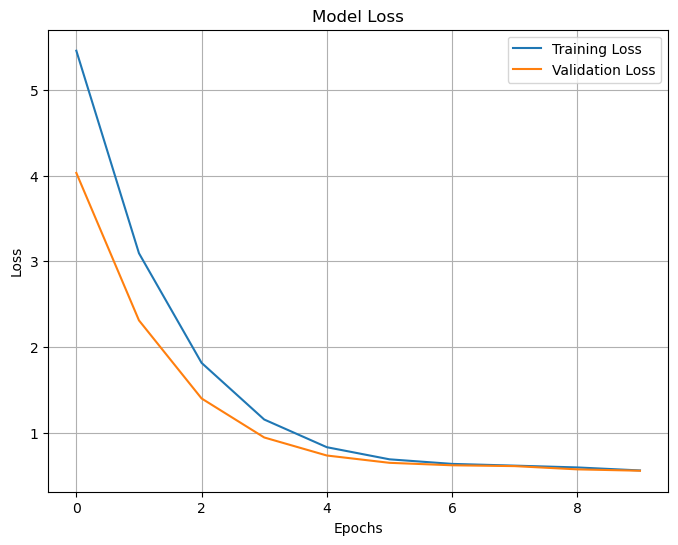

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6675 - loss: 0.6050
Test accuracy: 0.68
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

  No Spoiler       0.78      0.62      0.69      2007
     Spoiler       0.68      0.82      0.75      1993

    accuracy                           0.72      4000
   macro avg       0.73      0.72      0.72      4000
weighted avg       0.73      0.72      0.72      4000



In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# plot model loss
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(history)
test_loss, test_accuracy = gru0.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_prob = adam_lstm.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary (0/1)

report = classification_report(y_test, y_pred, target_names=['No Spoiler', 'Spoiler'])
print(report)

**Interpretation**: Very stable learning curves with steady and relatively fast convergence for both train and val loss. Adam dynamically adjusts learning rates (based on 1st and 2nd moments of gradients) helping smoothing out convergence.

Test accuracy of 0.68. While convergence was good, did not outperform other optimizers (see below other optimizers)

model favors recall for spoiler class (0.82) at the cost of lower precision (0.68): more aggresive in identifying Spoiler reviews but confuses some false positives. --> **Bias**: slight bias toward Spoiler class.

Trade-offs: More computational cost than SGD (simplest) but better stability, convergence.

**Overall**: Adam is good at convergence and generalization but introduces a tendency toward higher recall for Spoilers.

#### **SGD**

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

sgd_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    
    LSTM(16, return_sequences=False, kernel_regularizer=l2(1e-1)),
    Dropout(0.7),  

    Dense(1, activation='sigmoid')
])

# Compile with SGD
sgd_lstm.compile(optimizer=SGD(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [71]:
# Early stopping and training

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = sgd_lstm.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10,batch_size=32, callbacks=[early_stopping])

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4541 - loss: 7.1258 - val_accuracy: 0.4256 - val_loss: 7.0390
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4680 - loss: 7.0098 - val_accuracy: 0.4263 - val_loss: 6.9249
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4725 - loss: 6.8967 - val_accuracy: 0.4238 - val_loss: 6.8129
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4954 - loss: 6.7847 - val_accuracy: 0.4244 - val_loss: 6.7028
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4938 - loss: 6.6754 - val_accuracy: 0.4250 - val_loss: 6.5948
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5196 - loss: 6.5674 - val_accuracy: 0.5919 - val_loss: 6.4887
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5301 - loss: 6.4622 - val_accuracy: 0.5925 - val_loss: 6.3846
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5339 - loss: 6.3587 - val_accuracy: 0.

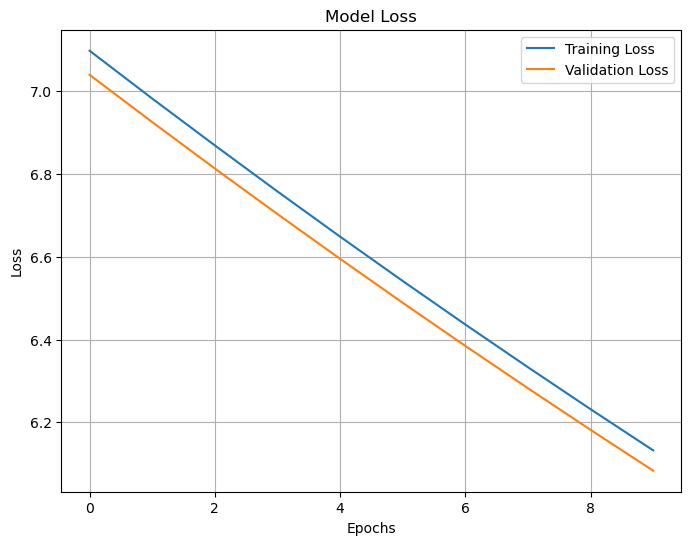

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6675 - loss: 0.6050
Test accuracy: 0.68
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

  No Spoiler       0.62      0.63      0.62      2007
     Spoiler       0.62      0.60      0.61      1993

    accuracy                           0.62      4000
   macro avg       0.62      0.62      0.62      4000
weighted avg       0.62      0.62      0.62      4000



In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# plot model loss
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(history)
test_loss, test_accuracy = gru0.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_prob = sgd_lstm.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary (0/1)

report = classification_report(y_test, y_pred, target_names=['No Spoiler', 'Spoiler'])
print(report)

**Interpretation**: 

Linear decrease of both loss curves indicating poor convergence (the model struggles to optimize effectively)

Test accuracy of 0.68, poor performance. The overall performance is low, likely due to the lack of lr adaptation.

Symmetry in metrics: precision, recall and F1 scores are almost identical for both classes --> no strong bias but also poor discriminative ability

**Overall**: Inability to optimize effectively, balanced but poor performance.

#### **SGD with Momentum**

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

sgd_m_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    
    LSTM(16, return_sequences=False, kernel_regularizer=l2(1e-1)),
    Dropout(0.7),  

    Dense(1, activation='sigmoid')
])

# Compile with SGD
sgd_m_lstm.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [75]:
# Early stopping and training

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = sgd_m_lstm.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10,batch_size=32, callbacks=[early_stopping])

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4658 - loss: 6.8922 - val_accuracy: 0.5838 - val_loss: 6.0976
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5566 - loss: 5.8616 - val_accuracy: 0.6206 - val_loss: 5.1983
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6188 - loss: 5.0017 - val_accuracy: 0.6737 - val_loss: 4.4488
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6348 - loss: 4.2850 - val_accuracy: 0.6744 - val_loss: 3.8234
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6604 - loss: 3.6855 - val_accuracy: 0.6737 - val_loss: 3.3011
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6509 - loss: 3.1888 - val_accuracy: 0.6725 - val_loss: 2.8648
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6588 - loss: 2.7712 - val_accuracy: 0.6725 - val_loss: 2.5000
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6665 - loss: 2.4202 - val_accuracy: 0.

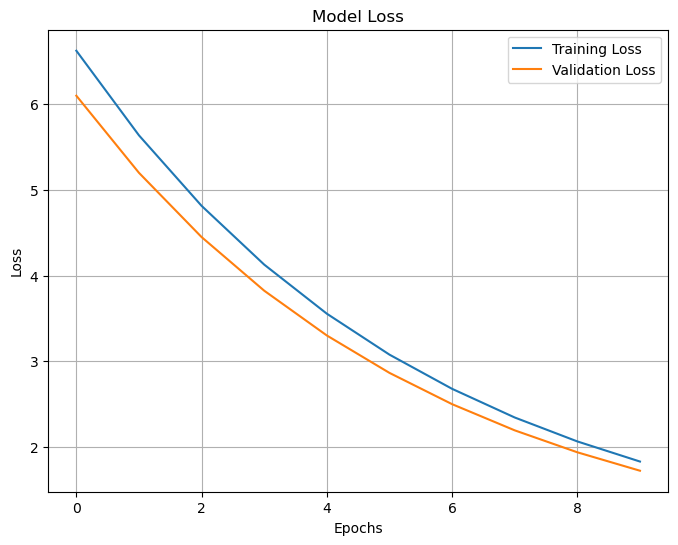

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6675 - loss: 0.6050
Test accuracy: 0.68
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

  No Spoiler       0.81      0.47      0.59      2007
     Spoiler       0.62      0.89      0.73      1993

    accuracy                           0.68      4000
   macro avg       0.72      0.68      0.66      4000
weighted avg       0.72      0.68      0.66      4000



In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# plot model loss
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(history)
test_loss, test_accuracy = gru0.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_prob = sgd_m_lstm.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary (0/1)

report = classification_report(y_test, y_pred, target_names=['No Spoiler', 'Spoiler'])
print(report)

**Interpretation**:

Improvement in stability compared to SGD. Train and val loss converge smoothly but also slowly and both decrease steadily. Plot shows that the model could benefit from more epochs in training.

Test accuracy of 0.68, poor performance.

Bias: the model has a high recall (0.89) but much lower precision (0.62). Model favor recall for spoilers at the expense of precision --> bias towards identifying Spoilers.

**Overall**: Improves convegence stability, but model is biased towards Spoiler identification resulting in class imbalance. 

#### **RMSprop**

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

rms_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    
    LSTM(16, return_sequences=False, kernel_regularizer=l2(1e-1)),
    Dropout(0.7),  

    Dense(1, activation='sigmoid')
])

# Compile with SGD
rms_lstm.compile(optimizer=RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [79]:
# Early stopping and training

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = rms_lstm.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10,batch_size=32, callbacks=[early_stopping])

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6130 - loss: 6.2035 - val_accuracy: 0.6737 - val_loss: 3.8590
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6631 - loss: 3.3026 - val_accuracy: 0.6725 - val_loss: 1.9335
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6672 - loss: 1.6510 - val_accuracy: 0.6700 - val_loss: 0.9862
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6703 - loss: 0.8820 - val_accuracy: 0.6719 - val_loss: 0.6606
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6697 - loss: 0.6478 - val_accuracy: 0.6725 - val_loss: 0.6183
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6620 - loss: 0.6305 - val_accuracy: 0.6712 - val_loss: 0.6166
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6719 - loss: 0.6164 - val_accuracy: 0.6719 - val_loss: 0.6123
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6733 - loss: 0.6136 - val_accu

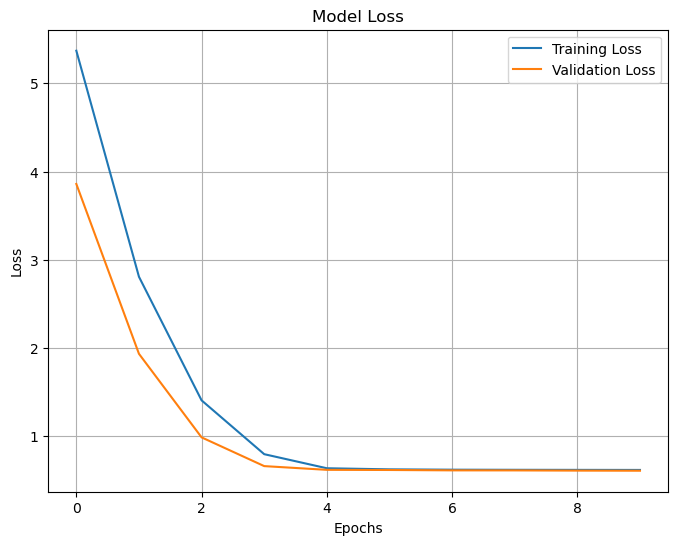

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6675 - loss: 0.6050
Test accuracy: 0.68
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

  No Spoiler       0.82      0.45      0.58      2007
     Spoiler       0.62      0.90      0.73      1993

    accuracy                           0.67      4000
   macro avg       0.72      0.67      0.66      4000
weighted avg       0.72      0.67      0.66      4000



In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# plot model loss
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(history)
test_loss, test_accuracy = gru0.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Predict on the test set
y_pred_prob = rms_lstm.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary (0/1)

report = classification_report(y_test, y_pred, target_names=['No Spoiler', 'Spoiler'])
print(report)

**Interpretation**: Smooth convergence for both curves. Also relatively fast convergence. 

Test accuracy of 0.68 indicates poor performance and generalization.

Similarly to SGD with momentum, RMSprop strongly favors the identification of Spoilers at the cost of lower precision: Spoiler recall (0.90) and precision (0.62) --> clear bias toward spoiler identification. 

**Overall**: smooth and fast convergence but shows clear bias in the spoiler class

**Overall Conclusion**: Despite exploring different architectures and trying with LSTM, GRU and different optimizers only a poor test accuracy of 0.73 was achieved. Despite the exploration and several fine tuning, the test accuracy stagnated at this value (0.73). This stagnation could be hapenning due to a number of reasons. It may sound counterintuitive to the inital logic when training lstm architectures, but I believe the model may be lacking sufficient complexity to learn effectively and generalize better. I say counterintuitive because, at the very beginning, I partially concluded that the model was overfitting and thus interpreted that the model had enough complexity to learn (besides having a very simple architecture: single lstm layer with 64 units and dropout). While it is not in the notebook, I even explored adding more complexity (increasing number of units and adding bidirectionality layer) but the test accuracy decreased even further (maintaining all other parameters equal). This further confirmed my thought that the model was complex enough, but I may have been mistaken. Additionally, the aggressive regularization can also be playing an important role in explaining the accuracy stagnation (dropout 0.7, l2 value 1e-1). 

If I were to continue improving the model, My immediate actions would involve trying other simple but more complex architectures and explore transfer learning by using pre trained word embeddings like GloVe or BERT to capture complex language patterns.